In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# RUL Prediction

In [69]:
df_rul = pd.read_csv("df_complete_with_rul.csv")

#Create sequences for LSTM
SEQ_LENGTH = 100 # use last 100 cycles to predict next SOH

def create_sequences(x, y, seq_length):
    x_seq, y_seq = [], [] #making standard sliding window For every index i 100 rows of X → input sequence and 100th value of y → target is taken
    for i in range(len(x) - seq_length):
        x_seq.append(x[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(x_seq), np.array(y_seq)

#Define R2 metric for Keras (evaluation metrics)
def r2_keras(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) #squared error
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) #variance of true values
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon()) #as R² = 1 - (error / total variance)


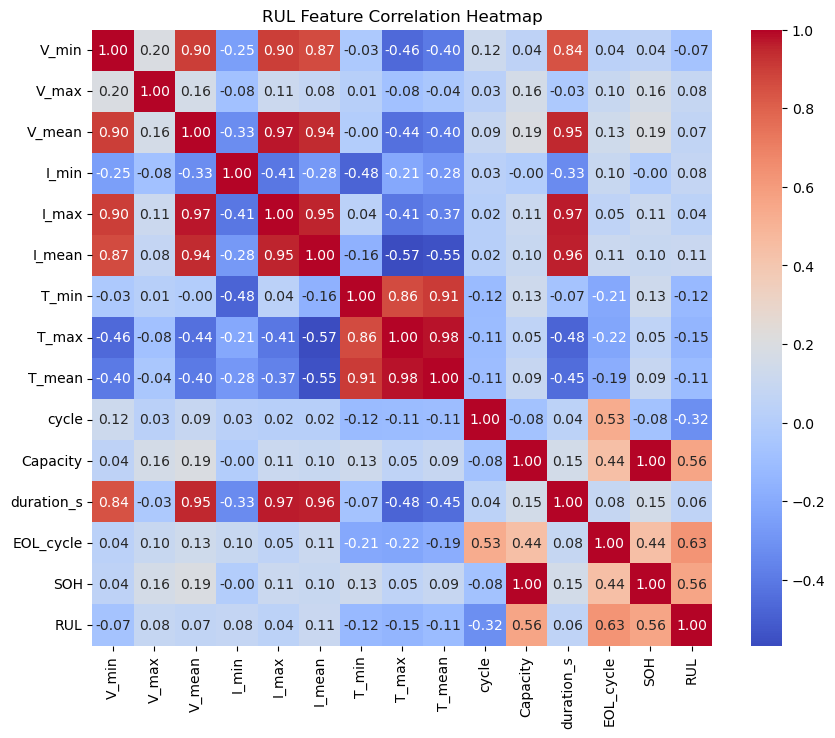

In [7]:
rul_cols = ['V_min','V_max','V_mean', 'I_min','I_max', 'I_mean', 'T_min','T_max', 'T_mean', 'cycle', 'Capacity', 'duration_s', 'EOL_cycle','SOH', 'RUL']
df_numerical = df_rul[rul_cols]
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('RUL Feature Correlation Heatmap')
plt.show()

In [71]:
# FEATURES & TARGET 
rul_feature_cols = [ 'T_max', 'I_mean', 'V_max','cycle', 'Capacity', 'EOL_cycle','SOH']
rul_target_col = 'RUL'

X = df_rul[rul_feature_cols].values 
Y = df_rul[rul_target_col].values.reshape(-1, 1)  # make 2D for scaler

# Scale inputs and target
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X) #fit_transform = learn scaling + apply scaling
Y_scaled = scaler_Y.fit_transform(Y)

X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, SEQ_LENGTH) #sequences for LSTM

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_seq, Y_seq, test_size=0.2, shuffle=False  # No shuffle for time series
)

#LSTM model 

rul_model = Sequential([
    Input(shape=(SEQ_LENGTH, len(rul_feature_cols))), #expects sequences of shape (100, 7 features)
    LSTM(64, activation='tanh', kernel_regularizer=l2(0.005), return_sequences=False ,recurrent_dropout=0.4), #main LSTM layer with recurrent dropout 
    Dropout(0.2),          # reduces overfitting
    Dense(16, activation='relu',kernel_regularizer=l2(0.005)),
    Dense(1, activation='linear') # Regression output
])

rul_model.compile(optimizer='adam', loss='mae', metrics=[r2_keras]) # Using MAE and R2 for evaluation
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [17]:
# Train model
history = rul_model.fit(
    X_train, Y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predict on test set
Y_pred_scaled = rul_model.predict(X_test)

# Inverse scale predictions (to convert scaled values back to original SOH units)
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_true = scaler_Y.inverse_transform(Y_test)

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.5187 - r2_keras: -1.2217 - val_loss: 0.5006 - val_r2_keras: -48.1004
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.4222 - r2_keras: -0.0849 - val_loss: 0.3940 - val_r2_keras: -23.1529
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3750 - r2_keras: 0.0851 - val_loss: 0.3978 - val_r2_keras: -26.4352
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3485 - r2_keras: 0.2822 - val_loss: 0.4297 - val_r2_keras: -37.4080
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.3087 - r2_keras: 0.3859 - val_loss: 0.4873 - val_r2_keras: -60.1726
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.2854 - r2_keras: 0.4880 - val_loss: 0.4025 - val_r2_keras: -35.5189
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2583 - r2_keras: 0.5767 - val_loss: 0.3859 - val_r2_keras: -33.5901
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.2421 - r2_keras: 0.6151 -

In [19]:
# Evaluate performance
# Testing results (MAE & R2)
rul_test_mae = mean_absolute_error(Y_true, Y_pred)
rul_test_r2 = r2_score(Y_true, Y_pred)

# Extract metrics from historyrul_
rul_train_mae = history.history['loss']              # because loss = MAE
rul_val_mae = history.history['val_loss']

rul_train_r2 = history.history['r2_keras']
rul_val_r2 = history.history['val_r2_keras']

# Final Training and Validation Results
rul_final_train_mae = rul_train_mae[-1]
rul_final_val_mae = rul_val_mae[-1]
rul_final_train_r2 = rul_train_r2[-1]
rul_final_val_r2 = rul_val_r2[-1]

print("\n RUL TRAINING RESULTS")
print(f"Final Train MAE: {rul_final_train_mae:.4f}")
print(f"Final Train R2:  {rul_final_train_r2:.4f}")
print("\n RUL VALIDATION RESULTS")
print(f"Final Val MAE:   {rul_final_val_mae:.4f}")
print(f"Final Val R2:    {rul_final_val_r2:.4f}")
print("\n RUL TESTING RESULTS")
print(f"Test MAE: {rul_test_mae:.4f}")
print(f"Test R2 Score:  {rul_test_r2:.4f}")



 RUL TRAINING RESULTS
Final Train MAE: 0.0460
Final Train R2:  0.8732

 RUL VALIDATION RESULTS
Final Val MAE:   0.0323
Final Val R2:    0.7236

 RUL TESTING RESULTS
Test MAE: 4.8551
Test R2 Score:  0.8976


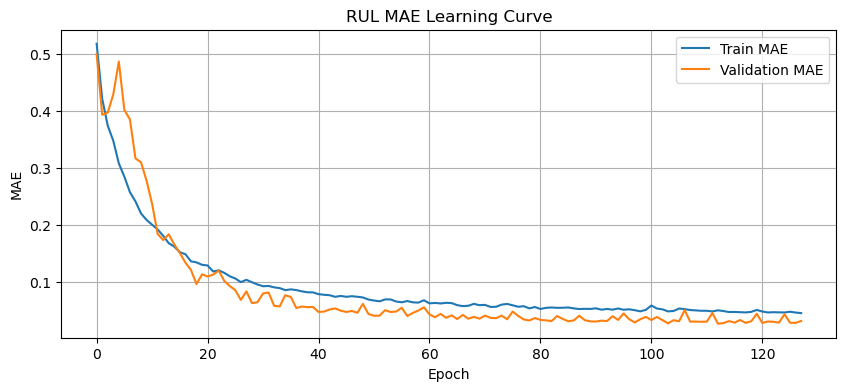

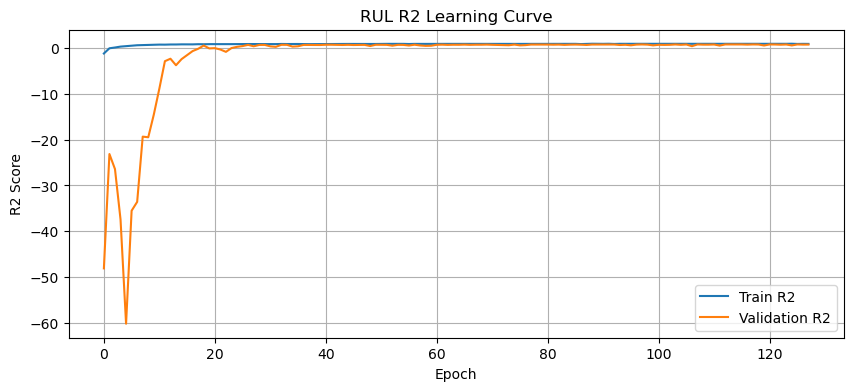

In [21]:
# Plot Learning Curves (MAE & R2)

# MAE plot 
plt.figure(figsize=(10,4))
plt.plot(rul_train_mae, label='Train MAE')
plt.plot(rul_val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('RUL MAE Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

#  R2 plot 
plt.figure(figsize=(10,4))
plt.plot(rul_train_r2, label='Train R2')
plt.plot(rul_val_r2, label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('RUL R2 Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
print("x_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", Y_test.shape)

x_train shape: (458, 100, 7)
y_train shape: (458, 1)
x_test shape: (115, 100, 7)
y_test shape: (115, 1)
